## Nominal Decision Tree

In [3]:
import numpy as np
import xarray as xr 
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
from scipy.stats import t

data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [4]:
rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

In [5]:
temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
tmax_reduced = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
tmin_reduced = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))
rain_reduced = block_reduce(rain, block_size=(12, 1, 1), func=np.mean, cval=np.mean(rain))
hurs_reduced = block_reduce(hurs, block_size=(12, 1, 1), func=np.mean, cval=np.mean(hurs))
sun_reduced = block_reduce(sun, block_size=(12, 1, 1), func=np.mean, cval=np.mean(sun))
frost_reduced = block_reduce(frost, block_size=(12, 1, 1), func=np.mean, cval=np.mean(frost))
psl_reduced = block_reduce(psl, block_size=(12, 1, 1), func=np.mean, cval=np.mean(psl))
wind_reduced = block_reduce(wind, block_size=(12, 1, 1), func=np.mean, cval=np.mean(wind))

In [6]:
min_length = len(wind_reduced)
rain = rain_reduced[:min_length]
hurs = hurs_reduced[:min_length]
temp_reduced = temp_reduced[:min_length]
tmax_reduced = tmax_reduced[:min_length]
tmin_reduced = tmin_reduced[:min_length]
sun = sun_reduced[:min_length]
frost = frost_reduced[:min_length]
wind = wind_reduced[:min_length]
psl = psl_reduced[:min_length]

In [33]:
scaler = MinMaxScaler()

rain = rain.flatten()
hurs = hurs.flatten()
temp_annual_mean = temp_reduced.flatten()
tmax_annual_mean = tmax_reduced.flatten()
tmin_annual_mean = tmin_reduced.flatten()
sun = sun.flatten()
frost = frost.flatten()
psl = psl.flatten()
wind = wind.flatten()

In [34]:
# Assuming temp, temp_max, and temp_min have shape (num_years, x, y)
num_years_temp, x, y = temp.shape

# Create an array of years to match the reshaped temperature arrays
years_expanded = np.repeat(np.arange(1969, 2023), x * y)

data_dict = {
    'Year': years_expanded,
    'Temperature': temp_annual_mean,
    'Maximum Temperature': tmax_annual_mean,
    'Minimum Temperature': tmin_annual_mean,
    'Rainfall': rain,
    'Humidity': hurs,
    'Ground Frost': frost,
    'Sunshine': sun,
    'Mean Sea Level Pressure': psl,
    'Wind Speed': wind
}

df = pd.DataFrame(data_dict)
df.set_index('Year', inplace=True)
df = df.sort_values(by='Year')
df.dropna(inplace=True)
df['Class'] = df.index.map(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

      Temperature  Maximum Temperature  Minimum Temperature  Rainfall  \
Year                                                                    
1969     6.950380            10.900596             3.138283  0.206214   
1969     6.604088            10.432849             2.901733  0.285411   
1969     5.954602             9.636578             2.450827  0.361803   
1969     6.962700             9.609509             4.750815  0.600102   
1969     6.361767             9.031652             4.420964  0.604795   
...           ...                  ...                  ...       ...   
2022     7.571890            11.010329             4.094268  0.247843   
2022     8.792969            12.533857             5.010300  0.166248   
2022     9.224189            13.121989             5.343364  0.127647   
2022     8.933711            12.661292             5.206832  0.126904   
2022     7.104376            10.143340             4.136392  0.359923   

      Humidity  Ground Frost  Sunshine  Mean Sea L

In [35]:
X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train, y_train)
print('Accuracy on training set: {:3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:3f}'.format(tree.score(X_test, y_test)))
scores = cross_val_score(tree, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)

Accuracy on training set: 0.738504
Accuracy on test set: 0.738596
Average Accuracy: 0.6823
95% Confidence Interval: (0.5949922759249797, 0.7695933727702102)


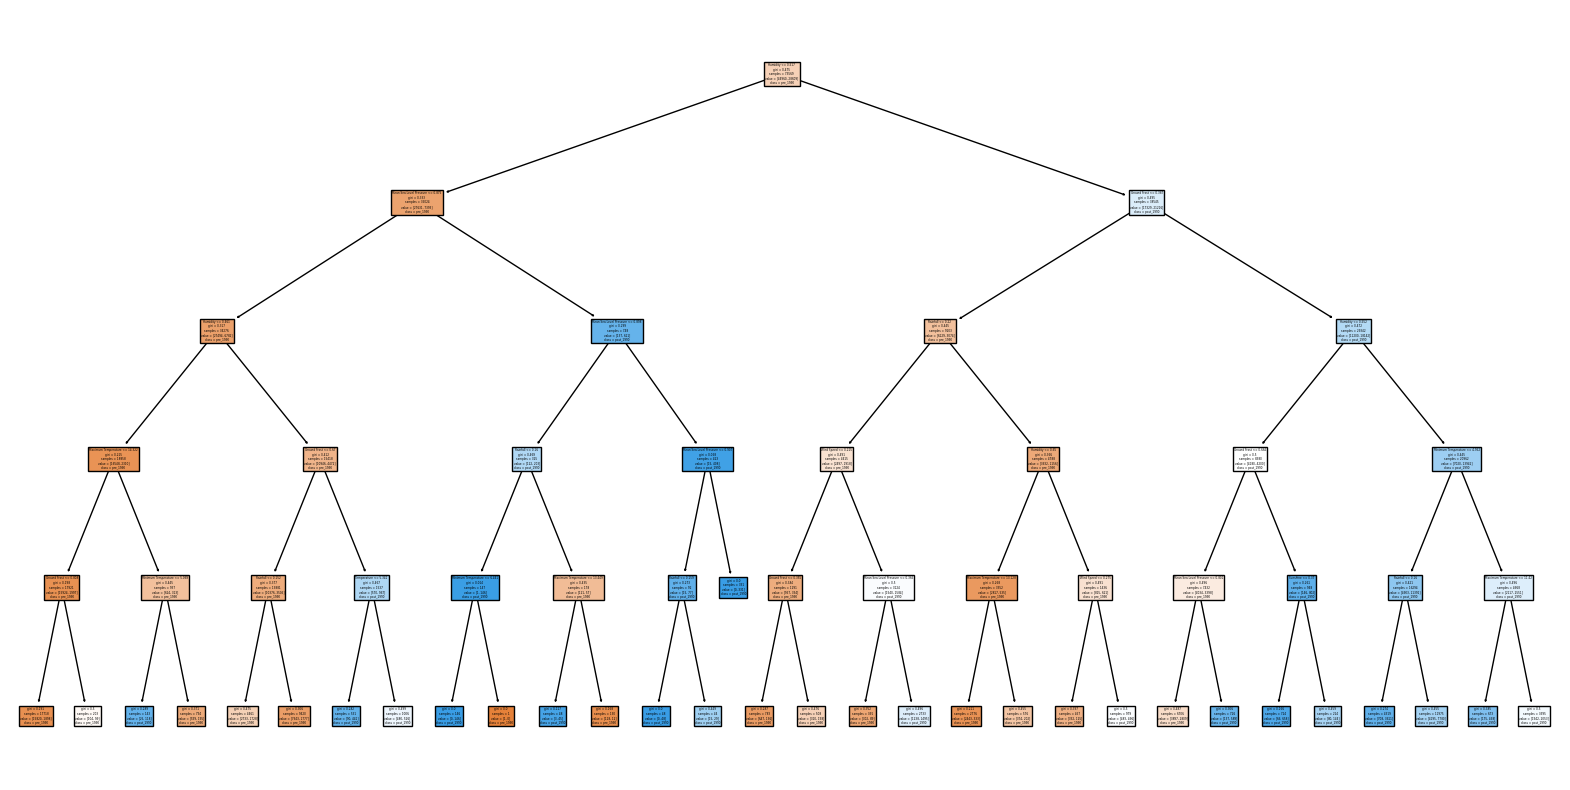

In [36]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].columns, class_names=df['Class'].unique())
plt.show()

Temperature: 0.0070
Maximum Temperature: 0.0265
Minimum Temperature: 0.0270
Rainfall: 0.0757
Humidity: 0.5525
Ground Frost: 0.1993
Sunshine: 0.0026
Mean Sea Level Pressure: 0.0938
Wind Speed: 0.0156


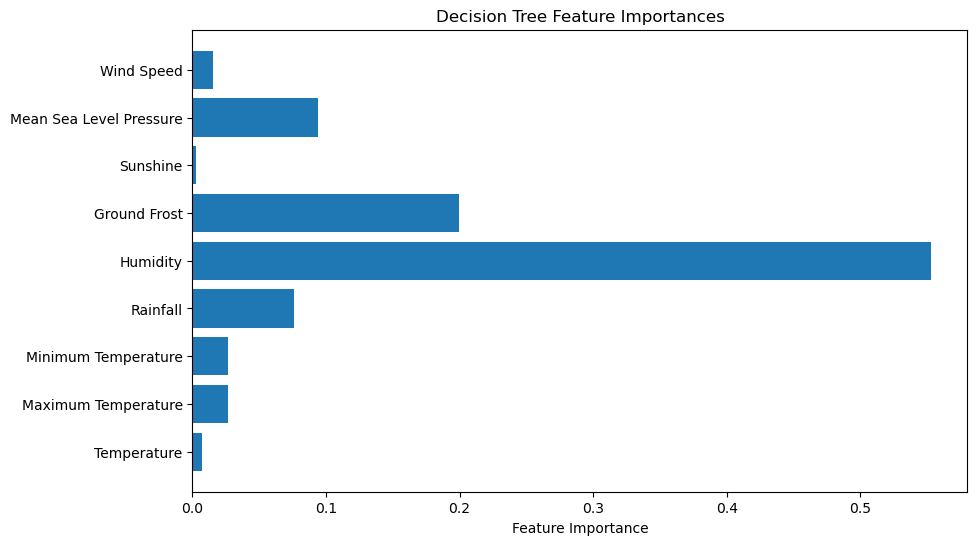

In [37]:
importances = tree.feature_importances_
feature_names = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].columns

for feature, importance in zip(feature_names, importances):
    print('{}: {:.4f}'.format(feature, importance))
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.show()

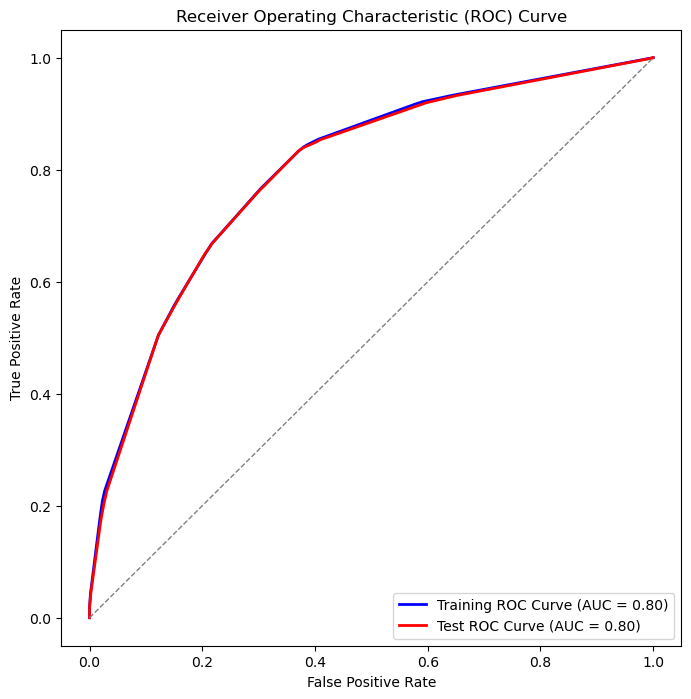

In [38]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = tree.predict_proba(X_train)[:, 1]
y_test_prob = tree.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Deeper Tree

In [60]:
X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=17, random_state=0)
tree.fit(X_train, y_train)
print('Accuracy on training set: {:3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:3f}'.format(tree.score(X_test, y_test)))
scores = cross_val_score(tree, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)

Accuracy on training set: 0.940315
Accuracy on test set: 0.819062
Average Accuracy: 0.6724
95% Confidence Interval: (0.5942354960083138, 0.7506248293036186)


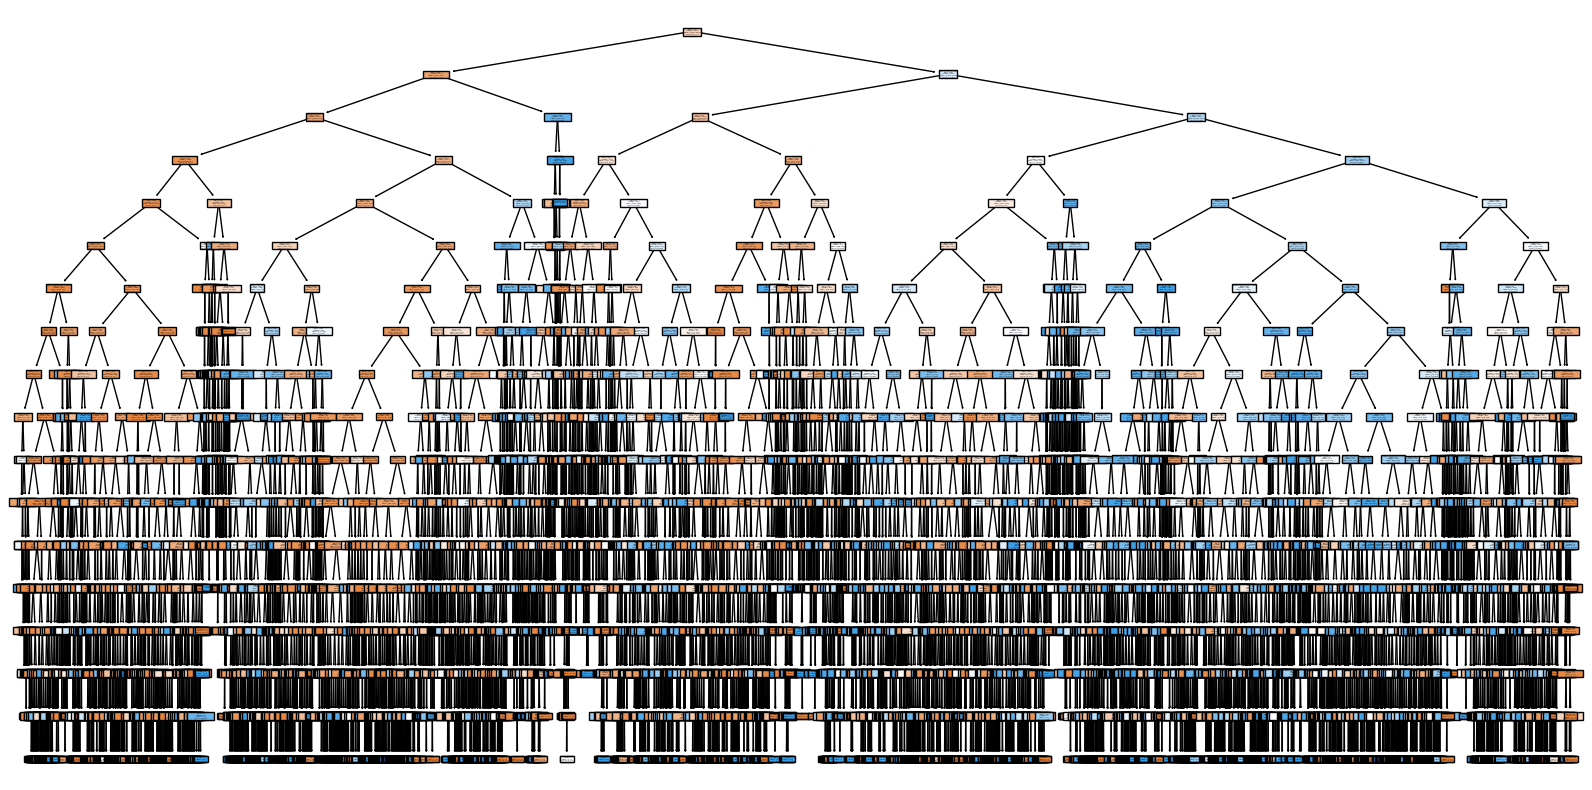

In [26]:
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].columns, class_names=df['Class'].unique())
plt.show()

Temperature: 0.0425
Maximum Temperature: 0.0760
Minimum Temperature: 0.0745
Rainfall: 0.1021
Humidity: 0.2381
Ground Frost: 0.1375
Sunshine: 0.0975
Mean Sea Level Pressure: 0.1734
Wind Speed: 0.0583


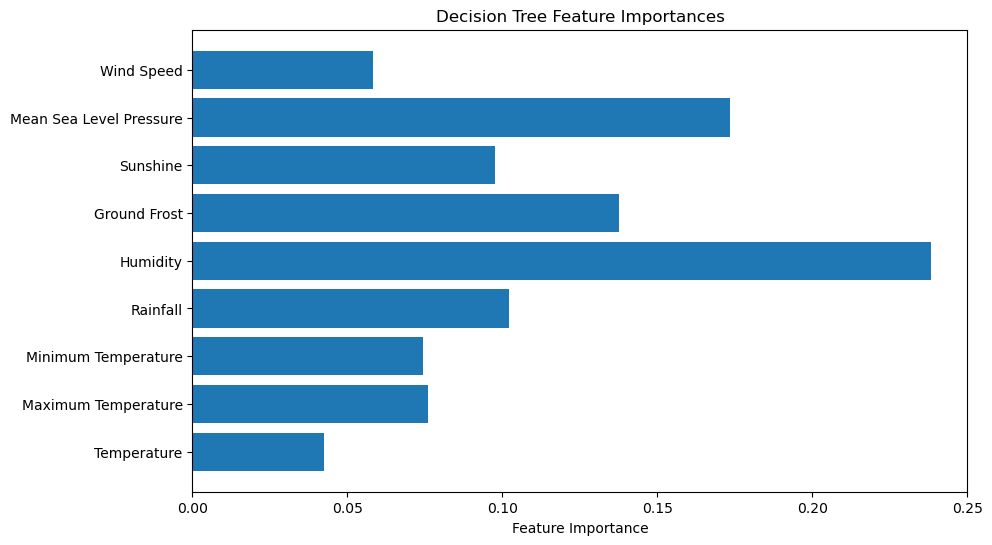

In [61]:
importances = tree.feature_importances_
feature_names = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].columns

for feature, importance in zip(feature_names, importances):
    print('{}: {:.4f}'.format(feature, importance))
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.show()

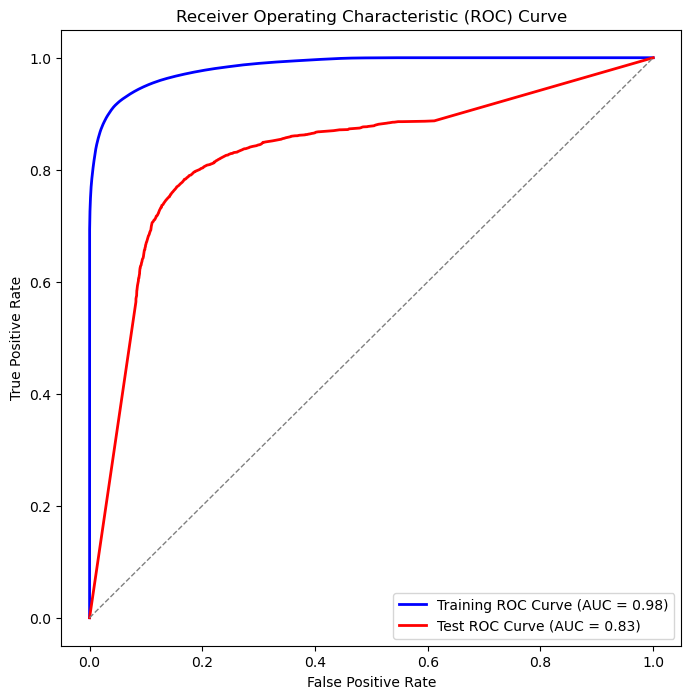

In [62]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = tree.predict_proba(X_train)[:, 1]
y_test_prob = tree.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The mean values of the classes are 0.7395110842207204 0.16629859597440422
The standard deviations of the classes are 0.38729515281223265 0.30626937743982185


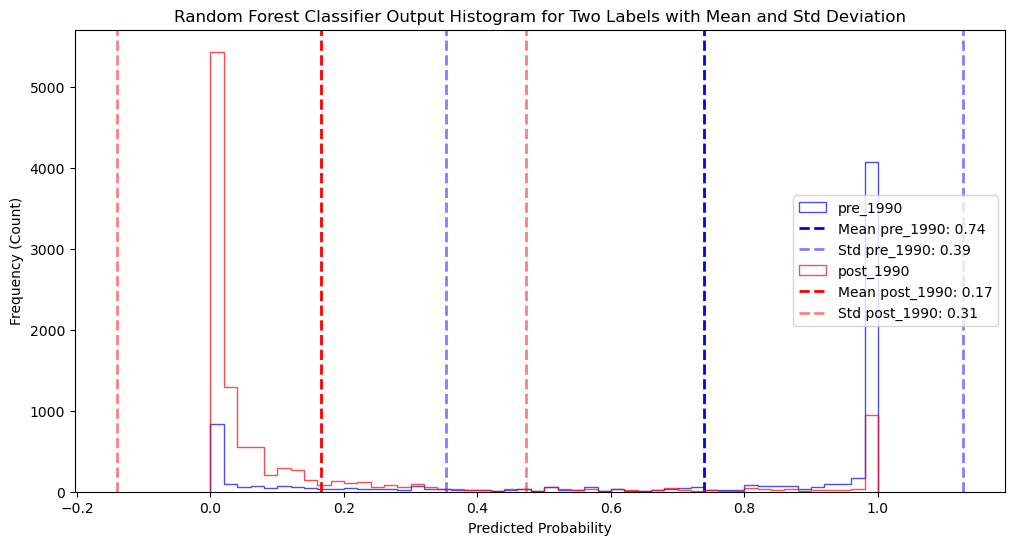

In [63]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = tree.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Calculate mean and standard deviation values
mean_label_1 = np.mean(data_label_1)
std_label_1 = np.std(data_label_1)

mean_label_2 = np.mean(data_label_2)
std_label_2 = np.std(data_label_2)

print('The mean values of the classes are', mean_label_1, mean_label_2)
print('The standard deviations of the classes are', std_label_1, std_label_2)

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')
plt.axvline(mean_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Mean {label_1}: {mean_label_1:.2f}')
plt.axvline(mean_label_1 + std_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Std {label_1}: {std_label_1:.2f}', alpha=0.5)
plt.axvline(mean_label_1 - std_label_1, color='blue', linestyle='dashed', linewidth=2, alpha=0.5)

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')
plt.axvline(mean_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Mean {label_2}: {mean_label_2:.2f}')
plt.axvline(mean_label_2 + std_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Std {label_2}: {std_label_2:.2f}', alpha=0.5)
plt.axvline(mean_label_2 - std_label_2, color='red', linestyle='dashed', linewidth=2, alpha=0.5)

plt.title('Random Forest Classifier Output Histogram for Two Labels with Mean and Std Deviation')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()

## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(random_state=0, n_estimators=150, max_features='sqrt')
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print('Accuracy on training set: {:3f}'.format(rf_classifier.score(X_train, y_train)))
print('Accuracy on test set: {:3f}'.format(rf_classifier.score(X_test, y_test)))

'''scores = cross_val_score(rf_classifier, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)'''

Accuracy on training set: 1.000000
Accuracy on test set: 0.886207


'scores = cross_val_score(rf_classifier, X, y, cv=5)  # 5-fold cross-validation\nprint("Average Accuracy: {:.4f}".format(scores.mean()))\nmean_score = scores.mean()\nconfidence = 0.95\nconfidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))\nprint(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)'

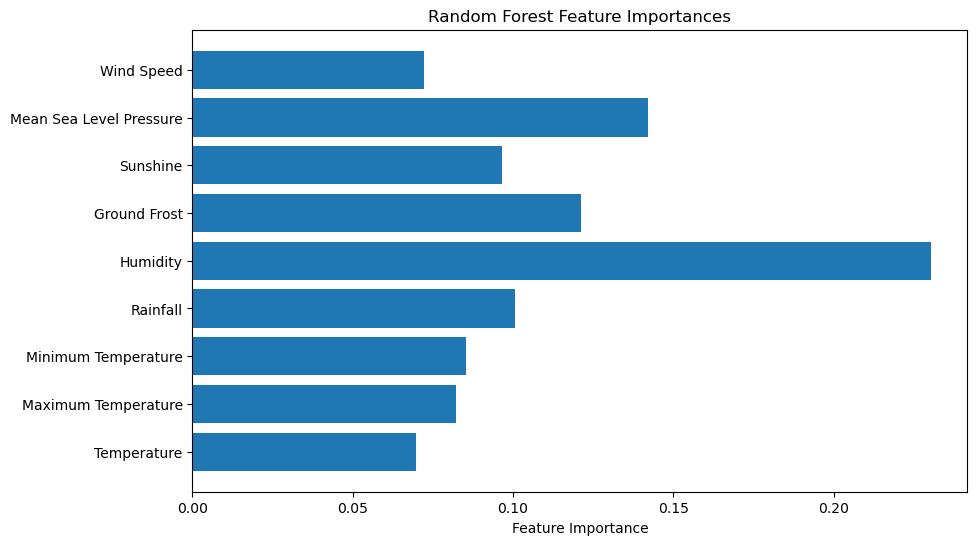

In [67]:
importances = rf_classifier.feature_importances_
feature_names = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].columns

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

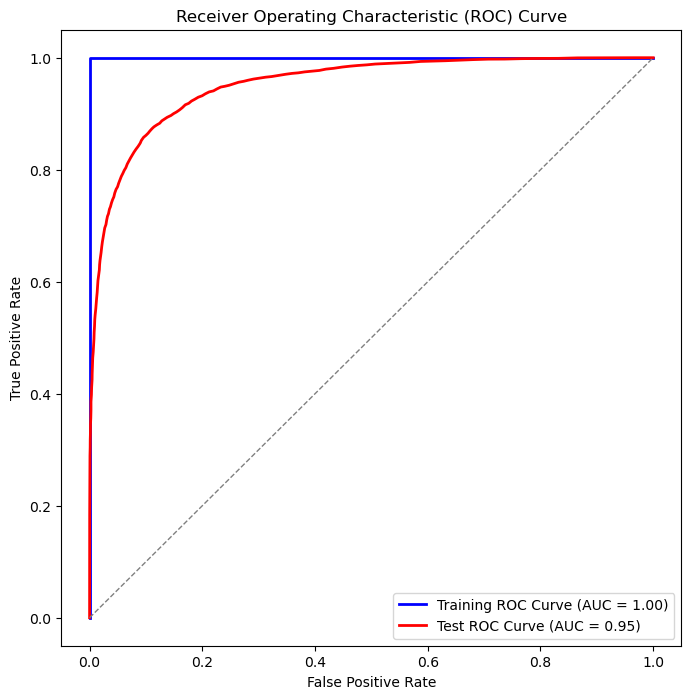

In [68]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = rf_classifier.predict_proba(X_train)[:, 1]
y_test_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The mean values of the classes are 0.7180157272684465 0.18079606387366684
The standard deviations of the classes are 0.22497584007133078 0.1760386338381538


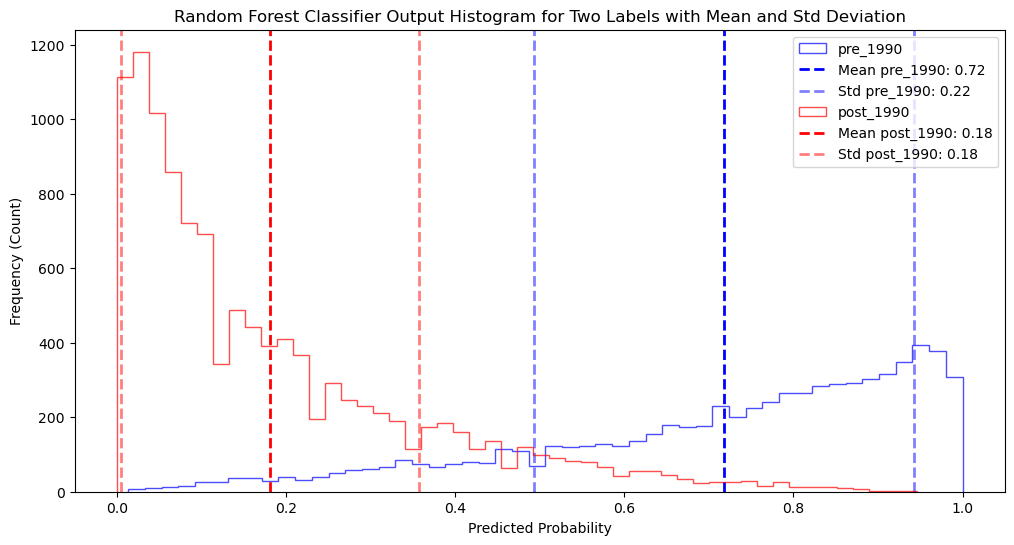

In [69]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Calculate mean and standard deviation values
mean_label_1 = np.mean(data_label_1)
std_label_1 = np.std(data_label_1)

mean_label_2 = np.mean(data_label_2)
std_label_2 = np.std(data_label_2)

print('The mean values of the classes are', mean_label_1, mean_label_2)
print('The standard deviations of the classes are', std_label_1, std_label_2)

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')
plt.axvline(mean_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Mean {label_1}: {mean_label_1:.2f}')
plt.axvline(mean_label_1 + std_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Std {label_1}: {std_label_1:.2f}', alpha=0.5)
plt.axvline(mean_label_1 - std_label_1, color='blue', linestyle='dashed', linewidth=2, alpha=0.5)

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')
plt.axvline(mean_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Mean {label_2}: {mean_label_2:.2f}')
plt.axvline(mean_label_2 + std_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Std {label_2}: {std_label_2:.2f}', alpha=0.5)
plt.axvline(mean_label_2 - std_label_2, color='red', linestyle='dashed', linewidth=2, alpha=0.5)

plt.title('Random Forest Classifier Output Histogram for Two Labels with Mean and Std Deviation')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()

## Ada Boosted Tree

In [70]:
from sklearn.ensemble import AdaBoostClassifier

X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].values
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a weak classifier (Decision Tree in this case)
base_classifier = DecisionTreeClassifier(max_depth=7, random_state=0)

# Instantiate the AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=150, learning_rate=0.1, random_state=0)

# Train the AdaBoost classifier
adaboost_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_classifier.predict(X_test)

print('Accuracy on training set: {:3f}'.format(adaboost_classifier.score(X_train, y_train)))
print('Accuracy on test set: {:3f}'.format(adaboost_classifier.score(X_test, y_test)))

'''scores = cross_val_score(adaboost_classifier, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))
mean_score = scores.mean()
confidence = 0.95
confidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))
print(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)'''

Accuracy on training set: 0.922889
Accuracy on test set: 0.865764


'scores = cross_val_score(adaboost_classifier, X, y, cv=5)  # 5-fold cross-validation\nprint("Average Accuracy: {:.4f}".format(scores.mean()))\nmean_score = scores.mean()\nconfidence = 0.95\nconfidence_interval = t.interval(confidence, len(scores) - 1, loc=mean_score, scale=sem(scores))\nprint(f"{int(confidence * 100)}% Confidence Interval:", confidence_interval)'

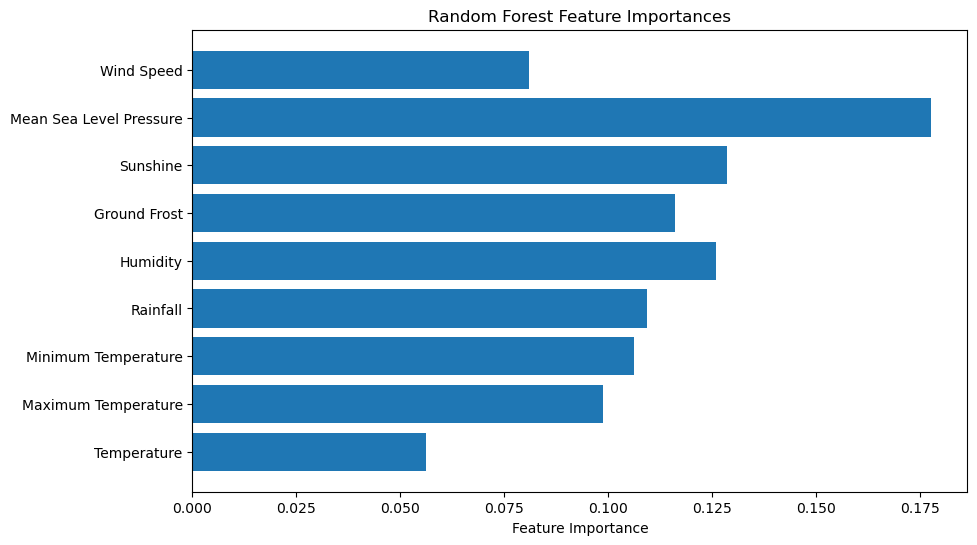

In [58]:
importances = adaboost_classifier.feature_importances_
feature_names = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Rainfall', 'Humidity', 'Ground Frost', 'Sunshine', 'Mean Sea Level Pressure', 'Wind Speed']].columns

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

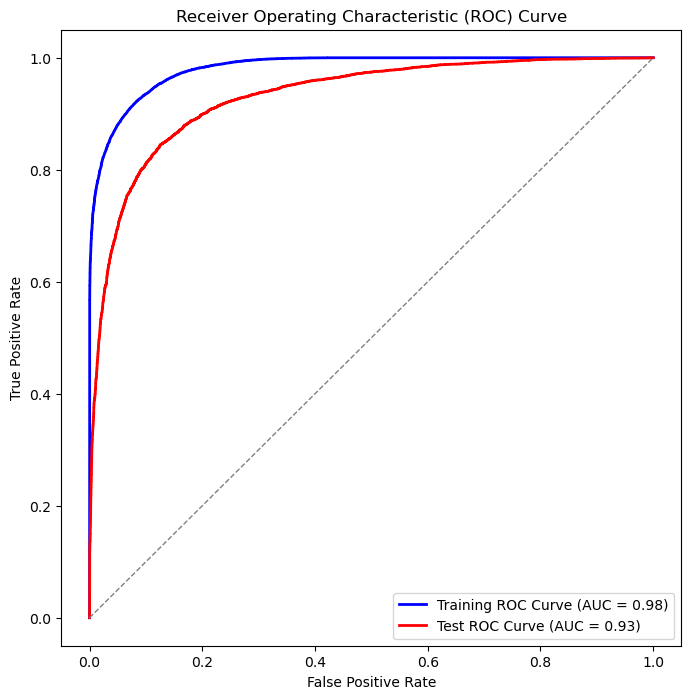

In [71]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = adaboost_classifier.predict_proba(X_train)[:, 1]
y_test_prob = adaboost_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The mean values of the classes are 0.5862341560985765 0.4031048977905718
The standard deviations of the classes are 0.12934875895181405 0.10597552713910197


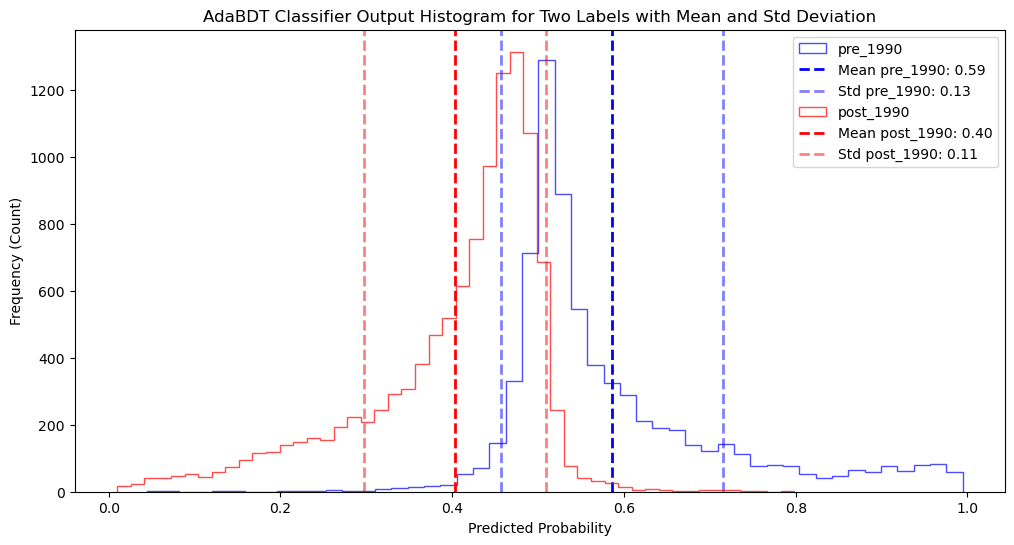

In [74]:
# Get the predicted probabilities for the positive class for the test set
y_test_prob = adaboost_classifier.predict_proba(X_test)[:, 1]

# Create a DataFrame with true labels and predicted probabilities
result_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Probability': y_test_prob
})

label_1 = 'pre_1990'
label_2 = 'post_1990'

# Filter the DataFrame for each label
data_label_1 = result_df[result_df['True_Label'] == label_1]['Predicted_Probability']
data_label_2 = result_df[result_df['True_Label'] == label_2]['Predicted_Probability']

# Calculate mean and standard deviation values
mean_label_1 = np.mean(data_label_1)
std_label_1 = np.std(data_label_1)

mean_label_2 = np.mean(data_label_2)
std_label_2 = np.std(data_label_2)

print('The mean values of the classes are', mean_label_1, mean_label_2)
print('The standard deviations of the classes are', std_label_1, std_label_2)

# Create histograms for each label using matplotlib without density normalization
plt.figure(figsize=(12, 6))

# Histogram for label_1
plt.hist(data_label_1, bins=50, alpha=0.7, label=f'{label_1}', color='blue', histtype='step')
plt.axvline(mean_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Mean {label_1}: {mean_label_1:.2f}')
plt.axvline(mean_label_1 + std_label_1, color='blue', linestyle='dashed', linewidth=2, label=f'Std {label_1}: {std_label_1:.2f}', alpha=0.5)
plt.axvline(mean_label_1 - std_label_1, color='blue', linestyle='dashed', linewidth=2, alpha=0.5)

# Histogram for label_2
plt.hist(data_label_2, bins=50, alpha=0.7, label=f'{label_2}', color='red', histtype='step')
plt.axvline(mean_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Mean {label_2}: {mean_label_2:.2f}')
plt.axvline(mean_label_2 + std_label_2, color='red', linestyle='dashed', linewidth=2, label=f'Std {label_2}: {std_label_2:.2f}', alpha=0.5)
plt.axvline(mean_label_2 - std_label_2, color='red', linestyle='dashed', linewidth=2, alpha=0.5)

plt.title('AdaBDT Classifier Output Histogram for Two Labels with Mean and Std Deviation')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency (Count)')
plt.legend()
plt.show()